In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import torch
import librosa
import librosa.display
import os
import re
import shutil
import random
import math
import pickle
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sklearn as sk
from sklearn import preprocessing as pp
from sklearn.model_selection import KFold

In [217]:
class SongData:
    def __init__(self):
        self.sid = 0
        self.sr = 0
        self.key = ""
        self.samples = [] # The original song info
        self.samples_30sec = [] # Random 30 second window
        
        self.qt_spec = [] # Constant Q-transform
        self.qt_spec_base = [] # Adapted constant Q-transform
        self.qt_spec_30sec = [] # Constant Q-transform of 30 sec
        self.qt_spec_resized = [] # Resized to uniform dimensions
        self.qt_spec_base_resized = []
        self.segment_specs = [] # Randomly stitched together spectograph segments

class SegmentSpectrumData:
    def __init__(self, spec, sid):
        self.spec = spec
        self.sid = sid
        self.segment_id = 0

# Loading

We start by configuring the source locations and loading the data

In [228]:
root_folder = "D:\Programming\_Projects\TU Wien - Data Science\WS 2022\ADL\\adl_ws22\\"

# Evaluation
eval_folder = root_folder + "eval\\"
data_folder = root_folder + "data\\"
model_folder = root_folder + "model\\"

# Audio
giantsteps_data_folder = data_folder + "giantsteps\\"
giantsteps_mtg_data_folder = data_folder + "giantsteps-mtg\\"

# Annotations
giantsteps_key_folder = eval_folder + "giantsteps_annotations\\key\\"
giantsteps_mtg_key_file = eval_folder + "giantsteps-mtg_annotations.txt"

In [229]:
# Loading the annotations
keys = {'song_id':[], 'key':[]}

for filename in os.listdir(giantstep_key_folder):
    f = os.path.join(giantsteps_key_folder, filename)
    # checking if it is a file
    if os.path.isfile(f):
        with open(f) as f:
            song_id = re.sub('\.LOFI\.key','',filename)
            key = f.read()
            keys['song_id'].append(song_id)
            keys['key'].append(key)
            
# Parsing the annotations into a dataframe
giantsteps_keys = pd.DataFrame.from_dict(keys).set_index('song_id')

In [230]:
key_equivalents = {re.compile('^G#'):'Ab',
                   re.compile('^A#'):'Bb',
                   re.compile('^C#'):'Db',
                   re.compile('^D#'):'Eb',
                   re.compile('^F#'):'Gb'}

giantsteps_mtg_keys = pd.read_csv(giantsteps_mtg_key_file, sep='\t').set_index('ID').drop('C',axis=1)
giantsteps_mtg_keys = giantsteps_mtg_keys.rename({'MANUAL KEY':'key'}, axis=1).replace(key_equivalents, regex=True)

Load the sample information

In [218]:
def generate_data_from_audio_folder(folder, key_df):
    data = dict()

    for filename in os.listdir(folder):
        f = os.path.join(data_giantsteps_folder, filename)
        # checking if it is a file
        if os.path.isfile(f):
            song_id = re.sub('\.LOFI\.mp3','', filename)
            if song_id in key_df.index:
                print(f"Loading song {song_id}", end="\r")
                y, sr = librosa.load(f)
                data[song_id] = SongData()
                data[song_id].samples = y
                data[song_id].sr = sr
    return data
    
giantsteps_data = generate_data_from_audio_folder(giantsteps_data_folder, giantsteps_keys)
giantsteps_mtg_data = generate_data_from_audio_folder(giantsteps_mtg_data_folder, giantsteps_mtg_keys)

Remove all songs that can't be decoded.

This only has to be executed once, and will only work if the files have previously been loaded without a specific sample rate. Librosa will then load some files with zero samples. These are the files that will crash the script when trying to resample while loading. So I moved them to a different folder and then re-ran the loading portion with the desired sample rate.

In [24]:
def move_unusable_files(folder, data):
    for sid in [i for i in data.keys() if len(data[i].samples)==0]:
        f = os.path.join(folder, sid + ".LOFI.mp3")
        f2 = os.path.join(folder, "undecodeable\\", sid + ".LOFI.mp3")
        shutil.move(f, f2)

# Feature extraction

I implement some base features to extract data from the given samples:
1. constant Q-transform spectrum as demonstrated by the reference project
2. Slightly modified Qt spectrum that focuses on the fundamental frequencies
3. A method to extract a random 30 second sample window

In [188]:
def extract_reference_spectograph(y, sr):
    window_length = 8192
    hop_length = window_length // 2
    octaves = 8
    bins_per_semitone = 2
    bins_per_octave = 12 * bins_per_semitone
    data = np.abs(librosa.cqt(y, sr=sr, hop_length=hop_length,
                              fmin=librosa.note_to_hz('C1'),
                              n_bins=bins_per_octave * octaves,
                              bins_per_octave=bins_per_octave))
    return data.astype(np.float16)

def extract_new_spectograph(y, sr):
    window_length = 8192
    hop_length = window_length // 2
    octaves = 3
    bins_per_semitone = 2
    bins_per_octave = 12 * bins_per_semitone
    data = np.abs(librosa.cqt(y, sr=sr, hop_length=hop_length,
                              fmin=librosa.note_to_hz('C1'),
                              n_bins=bins_per_octave * octaves,
                              bins_per_octave=bins_per_octave))
    return data.astype(np.float16)

def extract_k_sec_samples(samples:np.ndarray, sr:int, k:int) -> np.ndarray:
    k_sec_samples = sr * k
    num_samples = len(samples)
    final_startpoint = num_samples - k_sec_samples
    startpoint = random.sample(range(final_startpoint), k=1)[0]
    endpoint = startpoint + k_sec_samples
    return samples[startpoint:endpoint]

Some utility functions for the spectographs.
1. Resize all spectrographs by either cutting away excess columns, or repeating the spectograph from the start until filled.
2. Generate a spectograph equivalent to 30 seconds by randomly piecing together 5-second segments from the original spectograph (as a kind of bootstrap-based data-enhancement method).

In [189]:
def cut_and_fill_spectograph_to_k_col(spec:np.ndarray, k:int) -> np.ndarray:
    if spec.shape[1] > k:
        spec = spec[:,:k]
    elif spec.shape[1] < k:
        spec = repeat_spectograph_to_k_col(spec, k)
    return spec

def repeat_spectograph_to_k_col(spec:np.ndarray, k:int) -> np.ndarray:
    orig_l = spec.shape[1]
    diff = k - orig_l
    while True:
        attach_l = min([orig_l, diff])
        spec = np.concatenate((spec, spec[:,0:attach_l]),axis=1)
        diff = diff - attach_l
        if spec.shape[1] == k:
            break
    return spec

def random_segmentation_spectograph(spec:np.ndarray, target_w:int, segment_w:int) -> np.ndarray:
    num_passes = math.ceil(target_w/segment_w)
    segmented_spec = np.empty(shape=(spec.shape[0],target_w))
    final_startpoint = spec.shape[1] - segment_w
    for i in range(num_passes):
        startpoint = random.sample(range(final_startpoint),k=1)[0]
        endpoint = startpoint + segment_w
        new_segment = spec[:,startpoint:endpoint]
        l_col = i*segment_w
        r_col = (i+1)*segment_w
        segmented_spec[:,l_col:r_col] = new_segment
    return segmented_spec

Extracting the various styles of spectograph and storing them with my song data object

In [219]:
# Processing the samples
def parse_song_data(data):
    for sid in data.keys():
        song = data[sid]
        song.qt_spec = extract_reference_spectograph(song.samples, song.sr)
        song.qt_spec_base = extract_new_spectograph(song.samples, song.sr)    
        song.samples_30sec = extract_k_sec_samples(song.samples, song.sr, 30)
        song.qt_spec_30sec = extract_reference_spectograph(song.samples_30sec, song.sr)
        song.qt_spec_resized = cut_and_fill_spectograph_to_k_col(song.qt_spec, 646)
        song.qt_spec_base_resized = cut_and_fill_spectograph_to_k_col(song.qt_spec_base, 646)
        song.segment_specs = list()
        for i in range(5):
            song.segment_specs.append(
                SegmentSpectrumData(
                    spec = random_segmentation_spectograph(song.qt_spec, target_w=162, segment_w=27),
                    sid = sid
                )
            )
    return data

giantsteps_data = parse_song_data(giantsteps_data)
giantsteps_mtg_data = parse_song_data(giantsteps_mtg_data)

Storing the data for reuse.

In [220]:
# Store
pickle_filepath = data_folder + "giantsteps_data.obj"
fileObj = open(pickle_filepath, 'wb')
pickle.dump(giantsteps_data,fileObj)
fileObj.close()

pickle_filepath = data_folder + "giantsteps_mtg_data.obj"
fileObj = open(pickle_filepath, 'wb')
pickle.dump(giantsteps_mtg_data,fileObj)
fileObj.close()

In [6]:
# Load
pickle_filepath = data_folder + "giantsteps_data.obj"
fileObj = open(pickle_filepath, 'rb')
giantsteps_data = pickle.load(fileObj)
fileObj.close()

pickle_filepath = data_folder + "giantsteps_mtg_data.obj"
fileObj = open(pickle_filepath, 'rb')
giantsteps_mtg_data = pickle.load(fileObj)
fileObj.close()

C:\Users\Entenzahn\AppData\Local\Temp\ipykernel_32340\672468248.py:18: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sid_sample = random.sample(giantsteps_data.keys(), k=2)


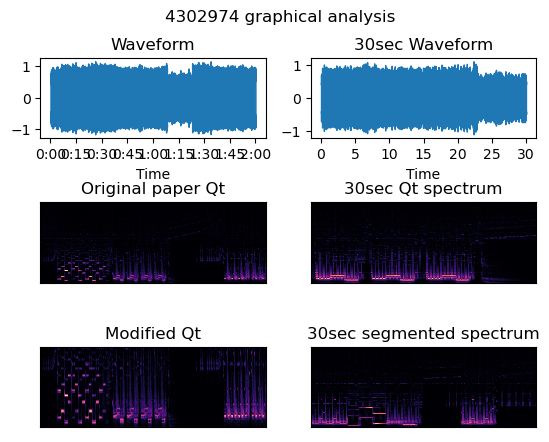

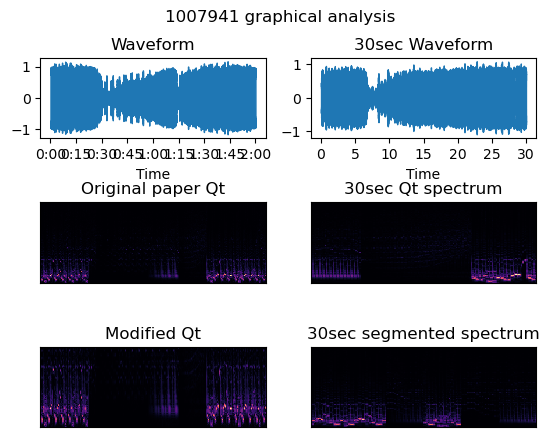

In [224]:
# Print visualization of random song objects
def print_song_info(song):
    fig, axs = plt.subplots(3,2)
    plt.subplots_adjust(hspace=0.8)
    fig.suptitle(f"{sid} graphical analysis")
    librosa.display.waveshow(song.samples, ax=axs[0,0])
    librosa.display.specshow(song.qt_spec, ax=axs[1,0])    
    librosa.display.specshow(song.qt_spec_base, ax=axs[2,0])
    librosa.display.waveshow(song.samples_30sec, ax=axs[0,1])
    librosa.display.specshow(song.qt_spec_30sec, ax=axs[1,1])
    librosa.display.specshow(song.segment_specs[0].spec, ax=axs[2,1])
    axs[0,0].set_title("Waveform")
    axs[1,0].set_title("Original paper Qt")
    axs[2,0].set_title("Modified Qt")
    axs[0,1].set_title("30sec Waveform")
    axs[1,1].set_title("30sec Qt spectrum")
    axs[2,1].set_title("30sec segmented spectrum")

sid_sample = random.sample(giantsteps_data.keys(), k=2)
for sid in sid_sample:
     print_song_info(giantsteps_data[sid])

In [197]:
# giantsteps_data['1695408'].qt_spec_30sec.shape == giantsteps_data['1695408'].segmented_specs[0].shape

True

Inputs:
1. Full inputs, pad smaller inputs by repeating the spectrum
2. Smaller windows of inputs
3. Data enhancement methods:

# Neural Network

The network architecture is based on InceptionKeyNet. However, as I kept adding the blocks, it seemed performance degrades. Likely, the architecture is overkill. I assume the task of identifying musical keys depends on a few base frequencies and cna be done with a more general network architecture.

In [297]:
class SimpleTestNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(113760, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 24)

    def forward(self, x):
        #print(x.device)
        #print(self.conv1.state_dict()['bias'].device)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class KeyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.drop_rate = 0.5
        
        self.drop_layer = nn.Dropout2d(p=self.drop_rate)
        
        self.stem_conv1 = nn.Conv2d(1, 6, 3, stride=2)
        self.stem_bn1 = nn.BatchNorm2d(6)
        self.stem_conv2 = nn.Conv2d(6, 6, 3)
        self.stem_bn2 = nn.BatchNorm2d(6)
        self.stem_conv3 = nn.Conv2d(6, 12, 3)
        self.stem_bn3 = nn.BatchNorm2d(12)
        self.stem_conv4 = nn.Conv2d(12, 19, 3)
        self.stem_bn4 = nn.BatchNorm2d(19)
        self.stem_conv5 = nn.Conv2d(19, 38, 3)
        self.stem_bn5 = nn.BatchNorm2d(38)
        
        self.block_a18_conv_left1 = nn.Conv2d(38, 9, 1)
        self.block_a18_bn_left1 = nn.BatchNorm2d(9)
        self.block_a18_conv_left2 = nn.Conv2d(9, 12, 5)
        self.block_a18_conv_mid1 = nn.Conv2d(38, 12, 1)
        self.block_a18_bn_mid1 = nn.BatchNorm2d(12)
        self.block_a18_conv_mid2 = nn.Conv2d(12, 19, 1)
        self.block_a18_bn_mid2 = nn.BatchNorm2d(19)
        self.block_a18_conv_mid3 = nn.Conv2d(19, 19, 5)
        self.block_a18_conv_right1 = nn.Conv2d(38, 18, 5)
        self.block_a18_bn_cat = nn.BatchNorm2d(18+19+12)
        
        self.block_a24_conv_left1 = nn.Conv2d(18+19+12, 9, 1)
        self.block_a24_bn_left1 = nn.BatchNorm2d(9)
        self.block_a24_conv_left2 = nn.Conv2d(9, 12, 5)
        self.block_a24_conv_mid1 = nn.Conv2d(18+19+12, 12, 1)
        self.block_a24_bn_mid1 = nn.BatchNorm2d(12)
        self.block_a24_conv_mid2 = nn.Conv2d(12, 19, 1)
        self.block_a24_bn_mid2 = nn.BatchNorm2d(19)
        self.block_a24_conv_mid3 = nn.Conv2d(19, 19, 5)
        self.block_a24_conv_right1 = nn.Conv2d(18+19+12, 24, 5)
        self.block_a24_bn_cat = nn.BatchNorm2d(24+19+12)
        
        self.block_b_conv_left1 = nn.Conv2d(24+19+12, 76, 3)
        self.block_b_conv_mid1 = nn.Conv2d(24+19+12, 12, 1)
        self.block_b_bn_mid1 = nn.BatchNorm2d(12)
        self.block_b_conv_mid2 = nn.Conv2d(12, 19, 3)
        self.block_b_bn_mid2 = nn.BatchNorm2d(19)
        self.block_b_conv_mid3 = nn.Conv2d(19, 19, 1)
        self.block_b_bn_cat = nn.BatchNorm2d(19+76)
        
        self.out_layer = nn.Linear(276556, 24)
        #self.out_layer = nn.Linear(453530, 24)        
        
    def forward(self, x):
        #print(x.device)
        #print(self.conv1.state_dict()['bias'].device)
        x = self.stem_bn1(F.relu(self.stem_conv1(x)))
        x = self.stem_bn2(F.relu(self.stem_conv2(x)))
        x = self.stem_bn3(F.relu(self.stem_conv3(x)))
        x = self.stem_bn4(F.relu(self.stem_conv4(x)))
        x = self.stem_bn5(F.relu(self.stem_conv5(x)))
        x = self.drop_layer(x)
                
        x_left = self.block_a18_bn_left1(F.relu(self.block_a18_conv_left1(x)))
        x_left = F.relu(self.block_a18_conv_left2(x_left))
        x_mid = self.block_a18_bn_mid1(F.relu(self.block_a18_conv_mid1(x)))
        x_mid = self.block_a18_bn_mid2(F.relu(self.block_a18_conv_mid2(x_mid)))
        x_mid = F.relu(self.block_a18_conv_mid3(x_mid))
        x_right = F.relu(self.block_a18_conv_right1(x))
        x = self.block_a18_bn_cat(torch.cat([x_left,x_mid,x_right],1))
        x = self.drop_layer(x)
                
        """x_left = self.block_a24_bn_left1(F.relu(self.block_a24_conv_left1(x)))
        x_left = F.relu(self.block_a24_conv_left2(x_left))
        x_mid = self.block_a24_bn_mid1(F.relu(self.block_a24_conv_mid1(x)))
        x_mid = self.block_a24_bn_mid2(F.relu(self.block_a24_conv_mid2(x_mid)))
        x_mid = F.relu(self.block_a24_conv_mid3(x_mid))
        x_right = F.relu(self.block_a24_conv_right1(x))
        x = self.block_a24_bn_cat(torch.cat([x_left,x_mid,x_right],1))
        x = self.drop_layer(x)
                
        x_left = F.relu(self.block_b_conv_left1(x))        
        x_mid = self.block_b_bn_mid1(F.relu(self.block_b_conv_mid1(x)))
        x_mid = self.block_b_bn_mid2(F.relu(self.block_b_conv_mid2(x_mid)))
        x_mid = F.relu(self.block_b_conv_mid3(x_mid))
        x = self.block_b_bn_cat(torch.cat([x_left,x_mid],1))
        x = self.drop_layer(x)"""
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.softmax(self.out_layer(x), dim=1)
        
        return x


class SpectralDataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, list_IDs, labels):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        X = torch.from_numpy(giantsteps_data[ID].qt_spec)[None].to(device)
        y = F.one_hot(torch.tensor(self.labels.loc[ID]).to(torch.int64), num_classes=24)

        return X, y


class SpectralDatasetNew(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, list_IDs, labels):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        X = torch.from_numpy(giantsteps_data[ID].qt_spec_30sec)[None].to(device)
        y = F.one_hot(torch.tensor(self.labels.loc[ID]).to(torch.int64), num_classes=24)

        return X, y


class SpectralDatasetSegmented(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, list_IDs, labels):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        X = torch.from_numpy(segment_data[ID].spec)[None].to(device)
        y = F.one_hot(torch.tensor(self.labels.loc[ID]).to(torch.int64), num_classes=24)

        return X, y

Splitting train, test and validation indices

In [225]:
# Datasets
train_frac = 0.8
val_frac_of_train = 0.2
num_samples = len(giantsteps_data.keys())
num_train_samples = round(num_samples * train_frac)
num_val_samples = round(num_train_samples * val_frac_of_train)

partition = dict()
partition['train_and_val'] = random.sample(giantsteps_data.keys(), k=num_train_samples)
partition['test'] =  [sid for sid in giantsteps_data.keys() if sid not in partition['train_and_val']]
partition['val'] = partition['train_and_val'][:num_val_samples]
partition['train'] = partition['train_and_val'][num_val_samples:]

len(partition['train']) + len(partition['test']) + len(partition['val']) == num_samples

C:\Users\Entenzahn\AppData\Local\Temp\ipykernel_32340\1869692134.py:9: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  partition['train_and_val'] = random.sample(giantsteps_data.keys(), k=num_train_samples)


True

To work with randomized-segment qt spectra, I need to establish a separate datastructure that passed them on like individual songs.

In [266]:
segment_data = dict()
segment_keys = dict()
segment_id = 0
for sid in giantsteps_data.keys():
    for segment_qt in giantsteps_data[sid].segment_specs:
        segment_qt.segment_id = segment_id
        segment_data[segment_id] = segment_qt
        segment_keys[segment_id] = dict()
        segment_keys[segment_id]['key'] = giantsteps_keys.loc[sid,'key']
        segment_id += 1
        
segment_keys = pd.DataFrame(segment_keys).transpose()

partition_segments = dict()
partition_segments['train'] = [segment_spec.segment_id for sid in partition['train'] for segment_spec in giantsteps_data[sid].segment_specs]
partition_segments['val'] = [segment_spec.segment_id for sid in partition['val'] for segment_spec in giantsteps_data[sid].segment_specs]
partition_segments['test'] =  [segment_spec.segment_id for sid in partition['test'] for segment_spec in giantsteps_data[sid].segment_specs]

WIP: Cross validation hyperparameter search?
Should probably use train_and_val partition for final training if I end up confirming hyperparameter performance with this method

In [66]:
tmp_keys = np.array(partition['train_and_val'])
kf = KFold(n_splits=5, shuffle=True, random_state=12002294)

for i, (train_idx, val_idx) in enumerate(kf.split(tmp_keys)):
    partition['train'] = tmp_keys[train_idx]
    partition['val'] = tmp_keys[val_idx]

At the moment I generate train, validation and test set. To get some idea of the performance, I run the split and compute the outcome multiple times.

In [279]:
# Parameters
params = {'batch_size': 32,
          'shuffle': False}
    
# One-Hot encoding for multilabel
le = pp.LabelEncoder()
labels = le.fit_transform(giantsteps_keys['key'])
giantsteps_keys['label'] = labels
labels = le.fit_transform(segment_keys['key'])
segment_keys['label'] = labels

# Generators
training_set = SpectralDatasetNew(partition['train'], giantsteps_keys['label'])
training_set = SpectralDatasetSegmented(partition_segments['train'], segment_keys['label'])
training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set = SpectralDatasetNew(partition['val'], giantsteps_keys['label'])
validation_set = SpectralDatasetSegmented(partition_segments['val'], segment_keys['label'])
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

test_set = SpectralDatasetNew(partition['test'], giantsteps_keys['label'])
#test_set = SpectralDatasetSegmented(partition['test'], segmented_keys_df['label'])
test_generator = torch.utils.data.DataLoader(test_set, **params)

To analyze if the label distribution is useable:

,label_train,label_val,label
key,,,
A major,45,5.0,5.0
A minor,165,60.0,35.0
Ab major,20,5.0,NaN
Ab minor,80,20.0,45.0
B major,20,5.0,NaN
B minor,120,20.0,10.0
Bb major,10,NaN,10.0
Bb minor,90,35.0,15.0
C major,40,20.0,10.0


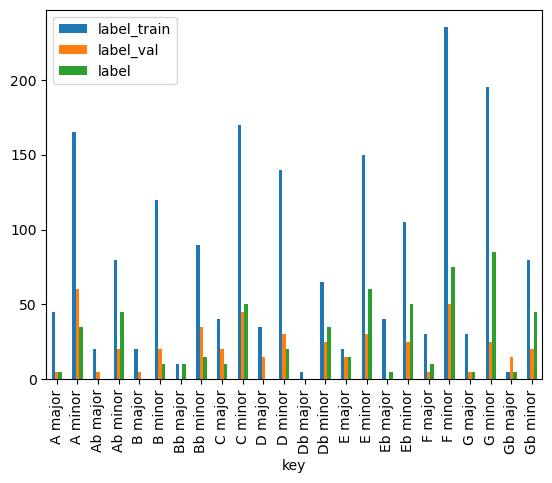

In [276]:
def analyze_label_distribution(keys, partition):
    counts = keys.loc[partition['train'],:].groupby(['key']).count().join(
        keys.loc[partition['val'],:].groupby(['key']).count(), lsuffix='_train', rsuffix='_val').join(
        keys.loc[partition['test'],:].groupby(['key']).count(), rsuffix='_test')
    display(counts)
    counts.plot.bar()
    
#analyze_label_distribution(giantsteps_keys, partition)
analyze_label_distribution(segment_keys, partition_segments)

In [298]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

#net = SimpleTestNet().to(device)
net = KeyNet().to(device)

criterion = nn.MultiLabelSoftMarginLoss()
optimizer_SGD = optim.SGD(net.parameters(), lr=0.01, momentum=0.8)
optimizer_Adam = optim.Adam(net.parameters(), lr=0.0001)

optimizer = optimizer_Adam

max_epochs = 150
callback = 50
best_epoch = 0

min_val_loss = np.inf

intermediate_model_location = root_folder + "model\optimal_weights.pth"

for epoch in range(max_epochs):  # loop over the dataset multiple times
    #print(f"{epoch}/{max_epochs}",end="\r")

    train_loss = 0.0
    net.train()
    for local_batch, local_labels in training_generator:
        
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        
        inputs = local_batch.float()
        labels = local_labels

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss += loss.item()
    
    val_loss = 0.0
    net.eval()
    for local_batch, local_labels in validation_generator:
        
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        
        inputs = local_batch.float()
        labels = local_labels
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

    if val_loss < min_val_loss:
        best_epoch = epoch
        min_val_loss = val_loss
        torch.save(net.state_dict(), intermediate_model_location)
        print(f'[{epoch+1}/{max_epochs}] train loss: {train_loss / len(training_generator)}\t| validation loss: {val_loss / len(validation_generator)} (new optimum)')
    else:
        print(f'[{epoch+1}/{max_epochs}] train loss: {train_loss / len(training_generator)}\t| validation loss: {val_loss / len(validation_generator)}')
        
    if epoch - best_epoch >= callback:
        print(f"No improvement for {callback} epochs - aborting training.")
        break

print('Finished Training')

net.load_state_dict(torch.load(intermediate_model_location))

[1/150] train loss: 0.7116034895181655	| validation loss: 0.7097303986549377 (new optimum)
[2/150] train loss: 0.701249090830485	| validation loss: 0.7010732094446818 (new optimum)
[3/150] train loss: 0.6903051873048146	| validation loss: 0.6998198866844177 (new optimum)
[4/150] train loss: 0.6857327620188395	| validation loss: 0.6991112073262532 (new optimum)
[5/150] train loss: 0.6841061820586523	| validation loss: 0.6993787010510762
[6/150] train loss: 0.6828729530175527	| validation loss: 0.6987790147463481 (new optimum)
[7/150] train loss: 0.6814874291419983	| validation loss: 0.6985404411951701 (new optimum)
[8/150] train loss: 0.6808260122934977	| validation loss: 0.6993262648582459
[9/150] train loss: 0.6804014533758164	| validation loss: 0.6983435074488322 (new optimum)
[10/150] train loss: 0.6799938092629115	| validation loss: 0.699178675810496
[11/150] train loss: 0.679717646042506	| validation loss: 0.699103848139445
[12/150] train loss: 0.679320901632309	| validation loss:

<All keys matched successfully>

Define functions to test accuracy and Mirex score:

In [133]:
def test(dataloader, model, loss_fn, cm):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.float().to(device), y.squeeze().to(device)
            pred = model(X)
            
            test_loss += loss_fn(pred, y).item()
            y_hat = pred.argmax(1)
            y_true = y.argmax(1)
            
            for i,v in enumerate(y_hat):
                cm.loc[v.item(),y_true[i].item()] += 1
            correct += (y_hat == y_true).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return cm

TONICS = ['Ab', 'A', 'Bb', 'B', 'C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G']

def compute_mirex_score(key, key_predicted):
    tonic = re.match('^[^\s]+',key).group(0)
    mode = re.search('[^\s]+$',key).group(0)
    
    tonic_predicted = re.match('^[^\s]+',key_predicted).group(0)
    mode_predicted = re.search('[^\s]+$',key_predicted).group(0)
    
    
    idx = TONICS.index(tonic)
    
    # True match
    if tonic == tonic_predicted and mode == mode_predicted:
        return 1
    # Perfect fifth relation
    elif (tonic_predicted == TONICS[(idx+7) % 12] or tonic_predicted == TONICS[idx-7 % 12]) and mode == mode_predicted:
        return 0.5
    # Relative minor/major
    elif (tonic_predicted== TONICS[(idx+3) % 12] and mode == 'minor' and mode_predicted == 'major') or (tonic_predicted == TONICS[(idx-3) % 12] and mode == 'major' and mode_predicted == 'minor'):
        return 0.3
    # Parallel minor/major
    elif tonic == tonic_predicted:
        return 0.2
    else:
        return 0

Test Error: 
 Accuracy: 53.4%, Avg loss: 0.696287 

Test Mirex score: 55.08474576271186


<AxesSubplot: >

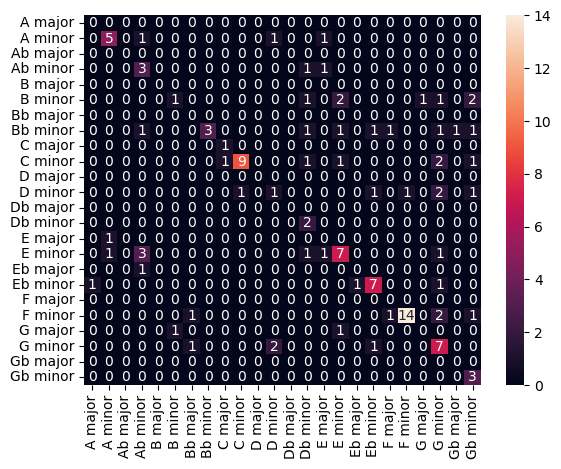

In [300]:
cm = pd.DataFrame(0, index=range(24), columns=range(24))
cm = test(test_generator, net, criterion, cm)
cm.index=le.inverse_transform(cm.index)
cm.columns=le.inverse_transform(cm.columns)

total = cm.sum().sum()
mirex_score = 0
for key in cm.columns:    
    for key_predicted in cm.loc[cm.loc[:,key] > 0, key].index:   
        #print(f"{key} vs {key_predicted}:{compute_mirex_score(key, key_predicted)}")     
        mirex_score += compute_mirex_score(key, key_predicted) * cm.loc[key,key_predicted]
        
print(f"Test Mirex score: {mirex_score/total*100}")

sn.heatmap(cm, annot=True)